# Amplitude Matching for Multizone Sound Field Control

A multizone sound field control method to synthesize a desired amplitude (or magnitude) distributions over a target region with multiple loudspeakers
- Paper: https://doi.org/10.1109/TASLP.2022.3231715
- Codes: https://github.com/sh01k/AmplitudeMatching

by Takumi Abe, [Shoichi Koyama](https://www.sh01.org/), [Natsuki Ueno](https://natsuenono.github.io/), and [Hiroshi Saruwatari](https://researchmap.jp/read0102891/)

## Codes for reproducing results in Sect. IV-A (2)
### General settings

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as distfuncs
from scipy import optimize
import time

import sf_func as sf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
plt.rcParams["font.size"] = 18 # Font size for plots

c = 340 # Sound speed (m/s)

# Simulated rectangular region 
lenX = 4.0 # Length in y
lenY = 4.0 # Length in y

dx, dy = 0.05, 0.05 # Intervals

# Simulated positions
xvecSim = np.arange(-lenX/2.0, lenX/2.0 + dx, dx)
yvecSim = np.arange(-lenY/2.0, lenY/2.0 + dy, dy)
ySim, xSim = np.meshgrid(yvecSim, xvecSim)
posSim = np.concatenate([xSim.reshape([-1,1]), ySim.reshape([-1,1])], 1)

# Number of simulated positions
numSimX = xSim.shape[0]
numSimY = xSim.shape[1]
numSim = (numSimX, numSimY)

### Table II and Figures 10 and 11: 3 target regions at single frequency

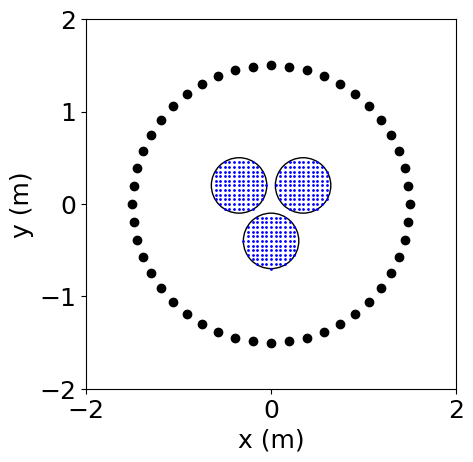

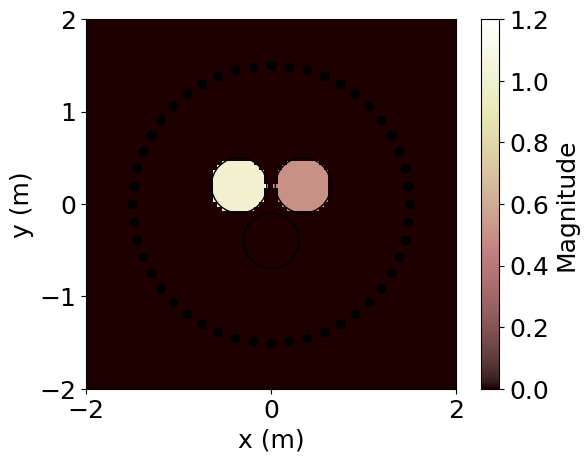

In [18]:
"""Parameters"""

freq = 1400 # Frequency
k = 2.0 * np.pi *freq / c # Wave number

radSPK = 1.5 # Radius of circlular loudspeaker array
numSPK = 48 # Number of loudspeakers
posSPK = sf.CircularGrid(radSPK, numSPK) # Loudspeaker positions

centCPlen = 0.2
radCP = 0.3 # Radius of circular target regions
centCP_UL = np.array([(-1)*centCPlen*np.sqrt(3), centCPlen])[None,:]
centCP_UR = np.array([centCPlen*np.sqrt(3), centCPlen])[None,:]
centCP_LC = np.array([0, -2*centCPlen])[None,:]
centCP = np.concatenate([centCP_UL, centCP_UR, centCP_LC], 0)

# Control points in upper left target region
distCP_UL = distfuncs.cdist(posSim, centCP_UL)
idxCP_UL = np.where(distCP_UL <= radCP)[0]
posCP_UL = posSim[idxCP_UL, :] 
numCP_UL = posCP_UL.shape[0]

# Control points in upper right target region
distCP_UR = distfuncs.cdist(posSim, centCP_UR)
idxCP_UR = np.where(distCP_UR <= radCP)[0]
posCP_UR = posSim[idxCP_UR, :] 
numCP_UR = posCP_UR.shape[0]

# Control points in lower target region
distCP_LC = distfuncs.cdist(posSim, centCP_LC)
idxCP_LC = np.where(distCP_LC <= radCP)[0]
posCP_LC = posSim[idxCP_LC, :] 
numCP_LC = posCP_LC.shape[0]

idxCP = np.concatenate([idxCP_UL, idxCP_UR, idxCP_LC]) # Indexes of total control points
posCP = posSim[idxCP, :] # Position of total control points
numCP = posCP.shape[0] # Number of control points

# Transfer Function Matrices
G = sf.TransFuncMat(posSPK, posCP, k)
GUL = sf.TransFuncMat(posSPK, posCP_UL, k) # For upper left target region
GUR = sf.TransFuncMat(posSPK, posCP_UR, k) # For upper right target region
GLC = sf.TransFuncMat(posSPK, posCP_LC, k) # For lower center target region

# Regularization parameter
U, s, V = np.linalg.svd(G.conj().T @ G)
reg = np.max(s) * 1e-3

# Desired amplitude distribution
des_UL = np.ones(numCP_UL)*1.0
des_UR = np.ones(numCP_UR)*0.5
des_LC = np.zeros(numCP_LC)
des = np.concatenate([des_UL, des_UR, des_LC])

desXY_vec = np.zeros(numSimX*numSimY)
desXY_vec[idxCP] = des
desXY = desXY_vec.reshape((numSimX, numSimY))

# Draw points
fig, ax = plt.subplots()
ax.scatter(posSPK[:,0], posSPK[:,1], c='k')
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posCP[:,0], posCP[:,1], s=1, c='b')
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, desXY, cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -4.7, MSE_UL: -0.9, MSE_UR: -7.0, MSE_LC: -27.0


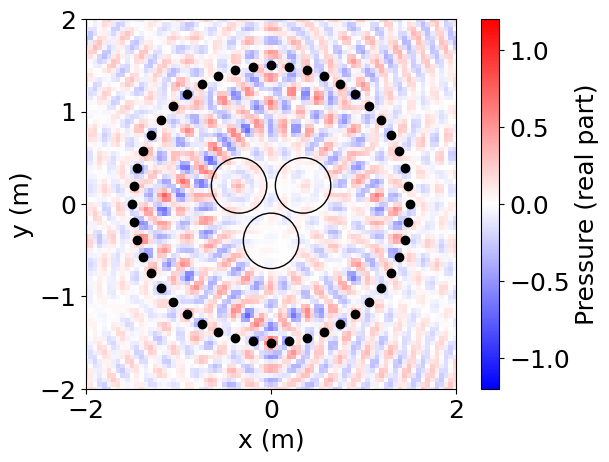

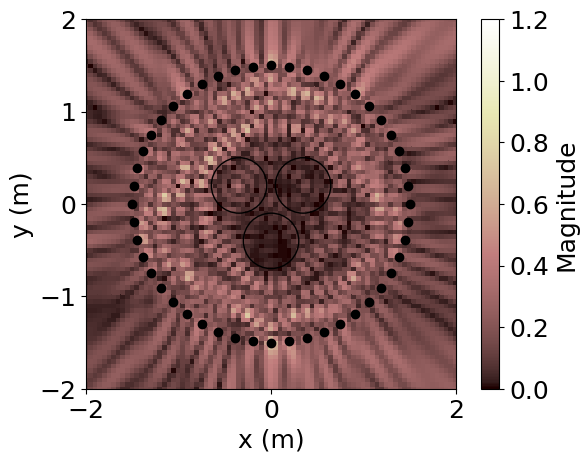

In [19]:
"""Pressure matching (PM) with zero phase"""

drvPM0 = sf.PressureMatching(G, reg, posSPK, des)
synPM0, synPM0_XY = sf.SynthSoundField(posSim, posSPK, drvPM0, numSim, k)

# Evaluation
MSE_PM0 = sf.MSE(synPM0[idxCP], des)
MSE_UL_PM0 = sf.MSE(synPM0[idxCP_UL], des_UL)
MSE_UR_PM0 = sf.MSE(synPM0[idxCP_UR], des_UR)
MSE_LC_PM0 = sf.MSE(synPM0[idxCP_LC], des_LC)

print("MSE: %.1f, MSE_UL: %.1f, MSE_UR: %.1f, MSE_LC: %.1f" % (MSE_PM0, MSE_UL_PM0, MSE_UR_PM0, MSE_LC_PM0) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synPM0_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synPM0_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -18.3, MSE_UL: -23.1, MSE_UR: -17.7, MSE_LC: -16.5


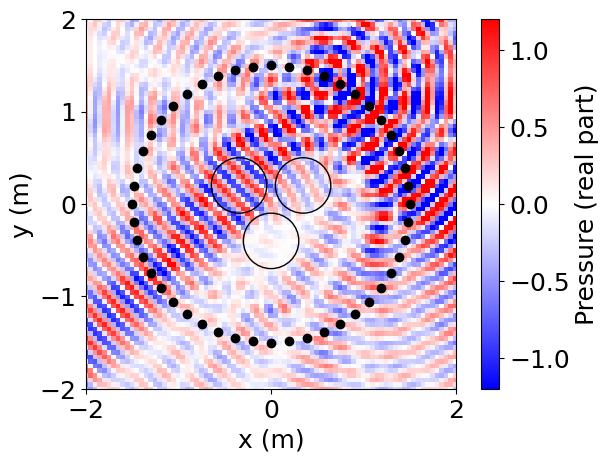

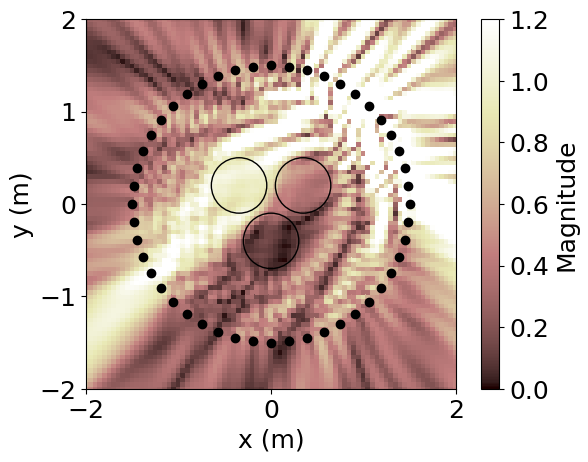

In [20]:
"""Pressure matching (PM) for synthesizing plane wave"""
# Plane wave propagation angle
pwAng_UL = 5.0*np.pi/4.0 
pwAng_UR = 7.0*np.pi/6.0 

des_UL_pw = sf.PlaneWave(1.0, pwAng_UL, posCP_UL, k)
des_UR_pw = sf.PlaneWave(0.5, pwAng_UR, posCP_UR, k)
des_pw = np.concatenate([des_UL_pw, des_UR_pw, des_LC])

drvPM = sf.PressureMatching(G, reg, posSPK, des_pw)
synPM, synPM_XY = sf.SynthSoundField(posSim, posSPK, drvPM, numSim, k)

# Evaluation
MSE_PM = sf.MSE(synPM[idxCP], des)
MSE_UL_PM = sf.MSE(synPM[idxCP_UL], des_UL)
MSE_UR_PM = sf.MSE(synPM[idxCP_UR], des_UR)
MSE_LC_PM = sf.MSE(synPM[idxCP_LC], des_LC)

print("MSE: %.1f, MSE_UL: %.1f, MSE_UR: %.1f, MSE_LC: %.1f" % (MSE_PM, MSE_UL_PM, MSE_UR_PM, MSE_LC_PM) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synPM_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synPM_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -6.6, MSE_UL: -2.7, MSE_UR: -8.9, MSE_LC: -51.7


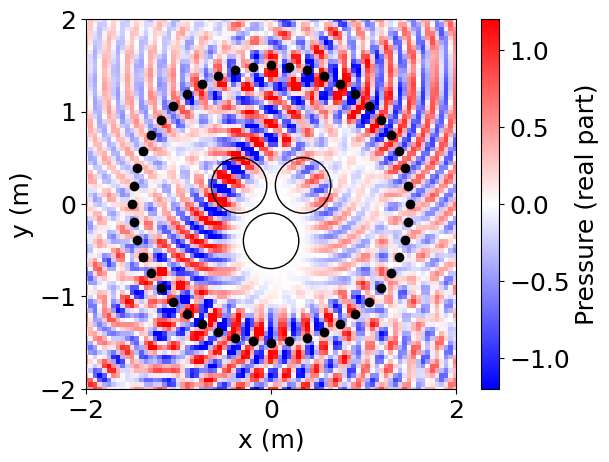

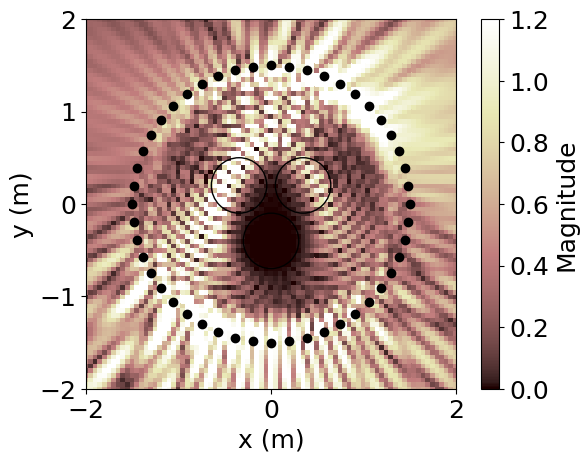

In [21]:
"""Acoustic contrast control (ACC)"""

drvACC_UL = sf.AcoustContrastControl(GUL, np.concatenate([GUR, GLC]))
synACCtmp, _ = sf.SynthSoundField(posSim, posSPK, drvACC_UL, numSim, k)
ampACC_UL = np.sqrt(synACCtmp[idxCP_UL].shape[0]) / np.linalg.norm(synACCtmp[idxCP_UL]) 
drvACC_UL = ampACC_UL * drvACC_UL

drvACC_UR = sf.AcoustContrastControl(GUR, np.concatenate([GUL, GLC]))
synACCtmp, _ = sf.SynthSoundField(posSim, posSPK, drvACC_UR, numSim, k)
ampACC_UR = np.sqrt(synACCtmp[idxCP_UR].shape[0]) / np.linalg.norm(synACCtmp[idxCP_UR]) 
drvACC_UR = ampACC_UR * drvACC_UR

drvACC = drvACC_UL + drvACC_UR * 0.5
synACC, synACC_XY = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)

# Evaluation
MSE_ACC = sf.MSE(synACC[idxCP], des)
MSE_UL_ACC = sf.MSE(synACC[idxCP_UL], des_UL)
MSE_UR_ACC = sf.MSE(synACC[idxCP_UR], des_UR)
MSE_LC_ACC = sf.MSE(synACC[idxCP_LC], des_LC)

print("MSE: %.1f, MSE_UL: %.1f, MSE_UR: %.1f, MSE_LC: %.1f" % (MSE_ACC, MSE_UL_ACC, MSE_UR_ACC, MSE_LC_ACC) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synACC_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synACC_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -21.5, MSE_UL: -21.3, MSE_UR: -20.8, MSE_LC: -22.4


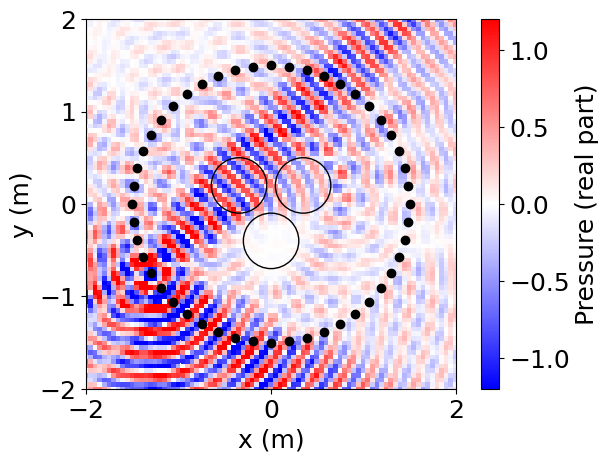

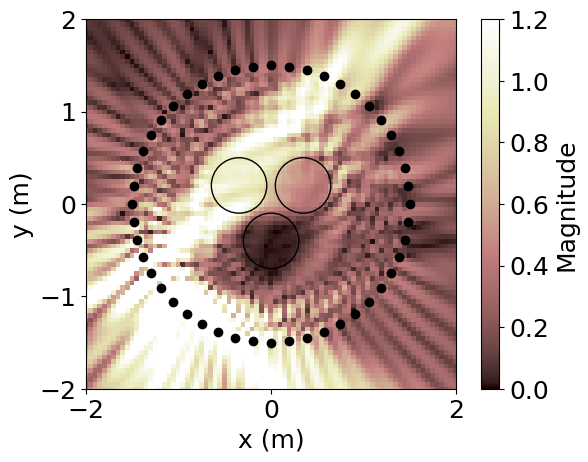

In [22]:
"""Amplitude matching by BFGS (AM-BFGS)"""

# Parameters
max_iter = 1000

# Initial value
drv0 = drvPM0
drv0Cmplx = np.concatenate([drv0.real, drv0.imag])

t_start = time.time()
resBFGS = optimize.minimize(sf.CostFuncCmplxAM, drv0Cmplx, method='BFGS', args=(G, des, reg, numSPK), jac=sf.GradCostFuncCmplxAM, options={'maxiter' : max_iter, 'return_all' : True})
t_end = time.time()
timeBFGS = t_end - t_start
drvAM_BFGS_CmplxList = resBFGS.allvecs

drvAM_BFGS = resBFGS.x[:numSPK] + 1j * resBFGS.x[numSPK:]
synAM_BFGS, synAM_BFGS_XY = sf.SynthSoundField(posSim, posSPK, drvAM_BFGS, numSim, k)

# Evaluation
MSE_AM_BFGS = sf.MSE(synAM_BFGS[idxCP], des)
MSE_UL_AM_BFGS = sf.MSE(synAM_BFGS[idxCP_UL], des_UL)
MSE_UR_AM_BFGS = sf.MSE(synAM_BFGS[idxCP_UR], des_UR)
MSE_LC_AM_BFGS = sf.MSE(synAM_BFGS[idxCP_LC], des_LC)

print("MSE: %.1f, MSE_UL: %.1f, MSE_UR: %.1f, MSE_LC: %.1f" % (MSE_AM_BFGS, MSE_UL_AM_BFGS, MSE_UR_AM_BFGS, MSE_LC_AM_BFGS) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synAM_BFGS_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synAM_BFGS_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -17.2, MSE_UL: -13.8, MSE_UR: -20.3, MSE_LC: -21.9


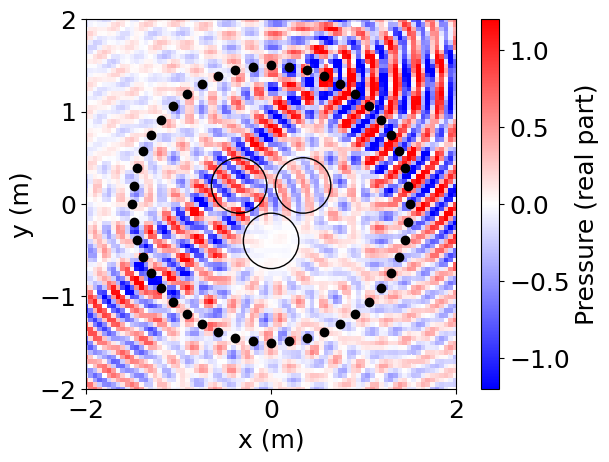

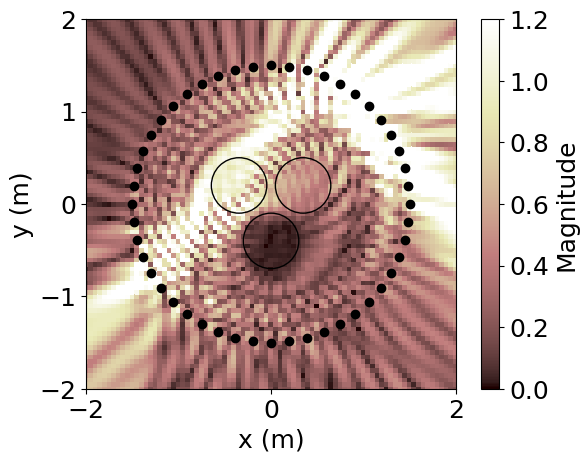

In [23]:
"""Amplitude matching by majorization minimization algorithm (AM-MM)"""

# Parameters
max_iter = 1000

# Initial value
drv0 = drvPM0

t_start = time.time()
drvAM_MM, drvAM_MM_List = sf.MM(numSPK, des, G, reg, drv0, max_iter=max_iter)
t_end = time.time()
timeMM = t_end - t_start
synAM_MM, synAM_MM_XY = sf.SynthSoundField(posSim, posSPK, drvAM_MM, numSim, k)

# Evaluation
MSE_AM_MM = sf.MSE(synAM_MM[idxCP], des)
MSE_UL_AM_MM = sf.MSE(synAM_MM[idxCP_UL], des_UL)
MSE_UR_AM_MM = sf.MSE(synAM_MM[idxCP_UR], des_UR)
MSE_LC_AM_MM = sf.MSE(synAM_MM[idxCP_LC], des_LC)

print("MSE: %.1f, MSE_UL: %.1f, MSE_UR: %.1f, MSE_LC: %.1f" % (MSE_AM_MM, MSE_UL_AM_MM, MSE_UR_AM_MM, MSE_LC_AM_MM) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synAM_MM_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synAM_MM_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -20.7, MSE_UL: -22.7, MSE_UR: -18.0, MSE_LC: -24.0


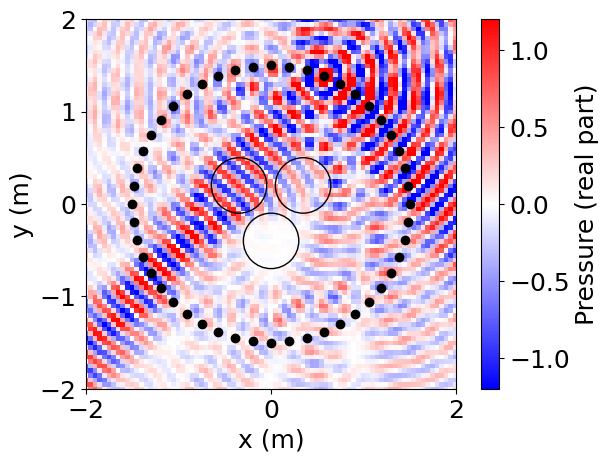

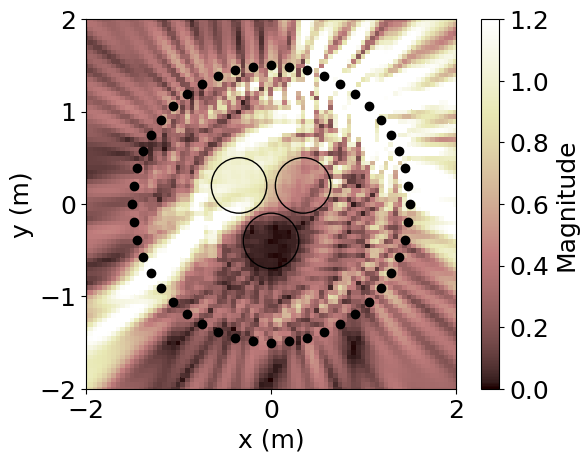

In [24]:
"""Amplitude matching by alternating direction method of multipliers (AM-ADMM) with PM (zero phase) for initial value"""

# Parameters
max_iter = 1000

# Initial value
drv0 = drvPM0

# ADMM
t_start = time.time()
drvAM_ADMM0, drvAM_ADMM0_List = sf.ADMM(numSPK, des, G, reg, drv0, max_iter=max_iter)
t_end = time.time()
timeADMM = t_end - t_start
synAM_ADMM0, synAM_ADMM0_XY = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM0, numSim, k)

# Evaluation
MSE_AM_ADMM0 = sf.MSE(synAM_ADMM0[idxCP], des)
MSE_UL_AM_ADMM0 = sf.MSE(synAM_ADMM0[idxCP_UL], des_UL)
MSE_UR_AM_ADMM0 = sf.MSE(synAM_ADMM0[idxCP_UR], des_UR)
MSE_LC_AM_ADMM0 = sf.MSE(synAM_ADMM0[idxCP_LC], des_LC)

print("MSE: %.1f, MSE_UL: %.1f, MSE_UR: %.1f, MSE_LC: %.1f" % (MSE_AM_ADMM0, MSE_UL_AM_ADMM0, MSE_UR_AM_ADMM0, MSE_LC_AM_ADMM0) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synAM_ADMM0_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synAM_ADMM0_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

MSE: -20.7, MSE_UL: -22.4, MSE_UR: -18.0, MSE_LC: -23.5


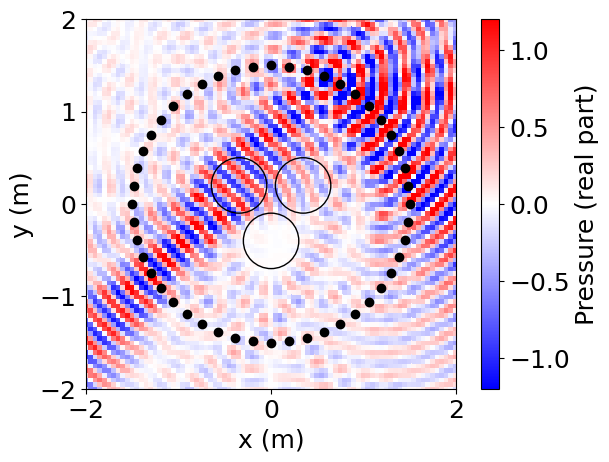

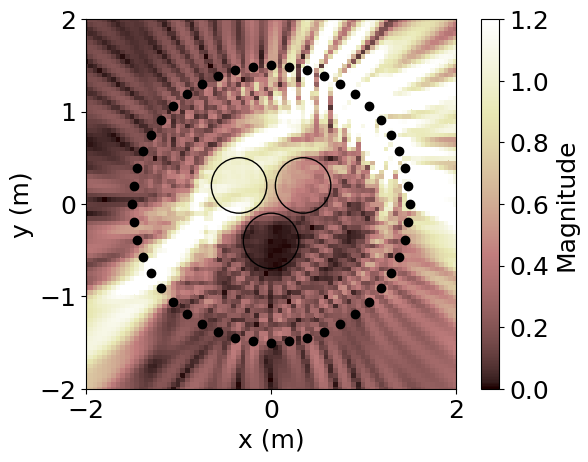

In [25]:
"""Amplitude matching by alternating direction method of multipliers (AM-ADMM) with PM for initial value"""

# Parameters
max_iter = 1000

# Initial value
drv0 = drvPM

# ADMM
drvAM_ADMM, _ = sf.ADMM(numSPK, des, G, reg, drv0, max_iter=max_iter)
synAM_ADMM, synAM_ADMM_XY = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM, numSim, k)

# Evaluation
MSE_AM_ADMM = sf.MSE(synAM_ADMM[idxCP], des)
MSE_UL_AM_ADMM = sf.MSE(synAM_ADMM[idxCP_UL], des_UL)
MSE_UR_AM_ADMM = sf.MSE(synAM_ADMM[idxCP_UR], des_UR)
MSE_LC_AM_ADMM = sf.MSE(synAM_ADMM[idxCP_LC], des_LC)

print("MSE: %.1f, MSE_UL: %.1f, MSE_UR: %.1f, MSE_LC: %.1f" % (MSE_AM_ADMM, MSE_UL_AM_ADMM, MSE_UR_AM_ADMM, MSE_LC_AM_ADMM) )

# Plot
fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synAM_ADMM_XY.real, cmap='bwr', vmin=-1.2, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Pressure (real part)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, np.abs(synAM_ADMM_XY), cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

plt.show()

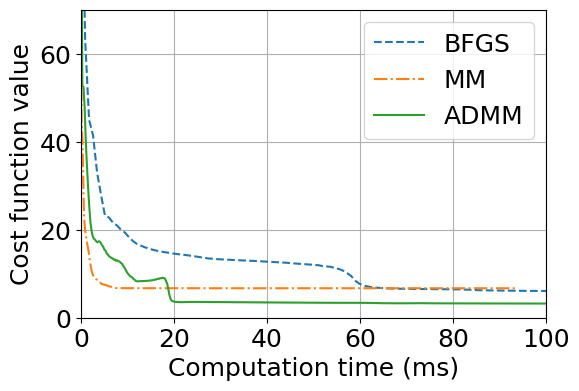

In [26]:
"""Computational time"""

numItrBFGS = len(drvAM_BFGS_CmplxList)
numItrMM = len(drvAM_MM_List)
numItrADMM = len(drvAM_ADMM0_List)

costBFGS = []
for i in range(numItrBFGS):
    drv = drvAM_BFGS_CmplxList[i][:numSPK] + 1j * drvAM_BFGS_CmplxList[i][numSPK:]
    costBFGS.append(sf.CostFuncAM(drv, G, des, reg))

costMM = []
for i in range(numItrMM):
    costMM.append(sf.CostFuncAM(drvAM_MM_List[i], G, des, reg))

costADMM = []
for i in range(numItrADMM):
    costADMM.append(sf.CostFuncAM(drvAM_ADMM0_List[i], G, des, reg))

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.linspace(0, timeBFGS*1000, numItrBFGS), costBFGS, label="BFGS", linestyle="dashed")
ax.plot(np.linspace(0, timeMM*1000, numItrMM), costMM, label="MM", linestyle="dashdot")
ax.plot(np.linspace(0, timeADMM*1000, numItrADMM), costADMM, label="ADMM")
ax.set_xlim(0, 100)
ax.set_ylim(0, 70)
plt.xlabel('Computation time (ms)')
plt.ylabel('Cost function value')
plt.grid()
plt.legend()

plt.show()


### Figure 8: Performance w.r.t. plane wave angles of desired sound field

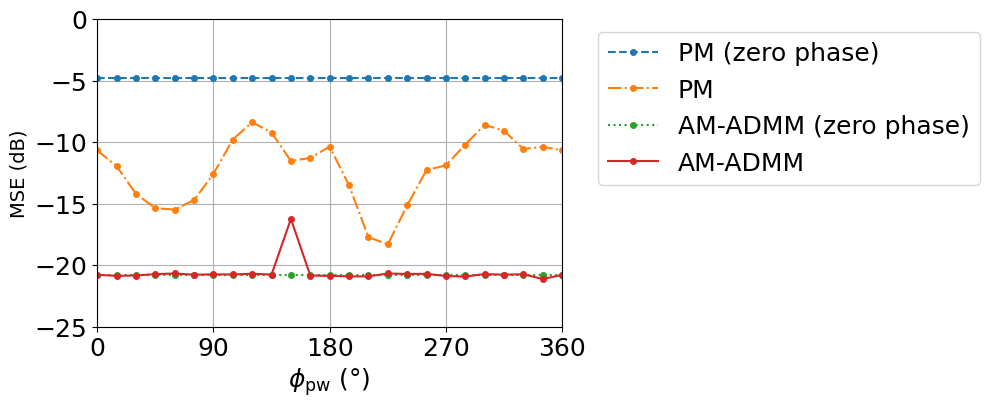

In [27]:
pwAng_UR = 7.0*np.pi/6.0 

numAng = 25
pwAngVec = np.arange(numAng)*360/(numAng-1)

MSEvec_PM = []
MSEvec_PM0 = []
MSEvec_AM_ADMM = []
MSEvec_AM_ADMM0 = []

for i in range(numAng):
    pwAng_UL = pwAngVec[i]*np.pi/180
    des_UL_pw = sf.PlaneWave(1.0, pwAng_UL, posCP_UL, k)
    des_UR_pw = sf.PlaneWave(0.5, pwAng_UR, posCP_UR, k)
    des_pw = np.concatenate([des_UL_pw, des_UR_pw, des_LC])

    # Pressure matching
    drvPM = sf.PressureMatching(G, reg, posSPK, des_pw)
    synPM, _ = sf.SynthSoundField(posSim, posSPK, drvPM, numSim, k)
    MSEvec_PM.append(sf.MSE(synPM[idxCP], des))

    # Amplitude matching
    drvAM_ADMM, _ = sf.ADMM(numSPK, des, G, reg, drvPM, max_iter=max_iter)
    synAM_ADMM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM, numSim, k)
    MSEvec_AM_ADMM.append(sf.MSE(synAM_ADMM[idxCP], des))

    MSEvec_PM0.append(MSE_PM0)
    MSEvec_AM_ADMM0.append(MSE_AM_ADMM0)
    
# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(pwAngVec, MSEvec_PM0, linestyle="--",marker="o",markersize=4, label="PM (zero phase)")
ax.plot(pwAngVec, MSEvec_PM, linestyle="-.",marker="o",markersize=4, label="PM")
ax.plot(pwAngVec, MSEvec_AM_ADMM0, linestyle=":",marker="o",markersize=4, label="AM-ADMM (zero phase)")
ax.plot(pwAngVec, MSEvec_AM_ADMM, linestyle="-",marker="o",markersize=4, label="AM-ADMM")
ax.set_xlim(0,360)
ax.set_ylim(-25, 0)
ax.set_xticks(np.linspace(0,360,5))
plt.xlabel(r'$\phi_{\rm{pw}}$ (°)')
plt.ylabel('MSE (dB)', fontsize = 14)
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.grid()

plt.show()


### Figure 9: Performance w.r.t. frequency

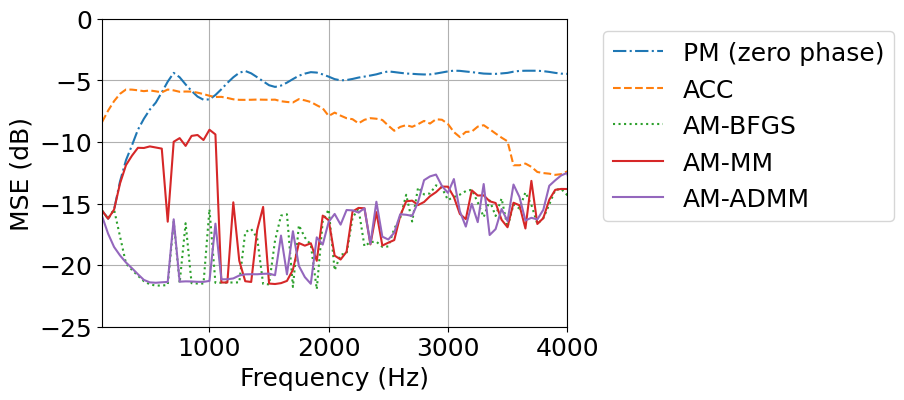

In [28]:
# Parameters
gtol = 1e-3
dtol = 1e-3
max_iter = 1000

freqVec = np.arange(100, 4100, 50)
numFreq = freqVec.shape[0]

MSEvec_PM0 = []
MSEvec_ACC = []
MSEvec_AM_BFGS = []
MSEvec_AM_MM = []
MSEvec_AM_ADMM = []

for i in range(numFreq):
    freq = freqVec[i] # Frequency
    k = 2.0 * np.pi *freq / c # Wave number

    # Transfer Function Matrices
    G = sf.TransFuncMat(posSPK, posCP, k)
    GUL = sf.TransFuncMat(posSPK, posCP_UL, k) # For upper left target region
    GUR = sf.TransFuncMat(posSPK, posCP_UR, k) # For upper right target region
    GLC = sf.TransFuncMat(posSPK, posCP_LC, k) # For lower center target region

    # Regularization parameter
    U, s, V = np.linalg.svd(G.conj().T @ G)
    reg = np.max(s) * 1e-3

    # PM (zero phase)
    drvPM0 = sf.PressureMatching(G, reg, posSPK, des)
    synPM0, _ = sf.SynthSoundField(posSim, posSPK, drvPM0, numSim, k)
    MSEvec_PM0.append(sf.MSE(synPM0[idxCP], des))

    # ACC
    drvACC_UL = sf.AcoustContrastControl(GUL, np.concatenate([GUR, GLC]))
    synACCtmp, _ = sf.SynthSoundField(posSim, posSPK, drvACC_UL, numSim, k)
    ampACC_UL = np.sqrt(synACCtmp[idxCP_UL].shape[0]) / np.linalg.norm(synACCtmp[idxCP_UL]) 
    drvACC_UL = ampACC_UL * drvACC_UL

    drvACC_UR = sf.AcoustContrastControl(GUR, np.concatenate([GUL, GLC]))
    synACCtmp, _ = sf.SynthSoundField(posSim, posSPK, drvACC_UR, numSim, k)
    ampACC_UR = np.sqrt(synACCtmp[idxCP_UR].shape[0]) / np.linalg.norm(synACCtmp[idxCP_UR]) 
    drvACC_UR = ampACC_UR * drvACC_UR

    drvACC = drvACC_UL + drvACC_UR * 0.5
    synACC, _ = sf.SynthSoundField(posSim, posSPK, drvACC, numSim, k)
    MSEvec_ACC.append(sf.MSE(synACC[idxCP], des))

    # AM-BFGS
    drv0Cmplx = np.concatenate([drvPM0.real, drvPM0.imag])
    resBFGS = optimize.minimize(sf.CostFuncCmplxAM, drv0Cmplx, method='BFGS', args=(G, des, reg, numSPK), jac=sf.GradCostFuncCmplxAM, options={'gtol': gtol, 'maxiter' : max_iter})
    drvAM_BFGS = resBFGS.x[:numSPK] + 1j * resBFGS.x[numSPK:]
    synAM_BFGS, _ = sf.SynthSoundField(posSim, posSPK, drvAM_BFGS, numSim, k)
    MSEvec_AM_BFGS.append(sf.MSE(synAM_BFGS[idxCP], des))

    # AM-MM
    drvAM_MM, _ = sf.MM(numSPK, des, G, reg, drvPM0, dtol=dtol, max_iter=max_iter)
    synAM_MM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_MM, numSim, k)
    MSEvec_AM_MM.append(sf.MSE(synAM_MM[idxCP], des))

    # AM-ADMM
    drvAM_ADMM, _ = sf.ADMM(numSPK, des, G, reg, drvPM0, dtol=dtol, max_iter=max_iter)
    synAM_ADMM, _ = sf.SynthSoundField(posSim, posSPK, drvAM_ADMM, numSim, k)
    MSEvec_AM_ADMM.append(sf.MSE(synAM_ADMM[idxCP], des))

# Plot
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(freqVec, MSEvec_PM0, linestyle="-.", label="PM (zero phase)")
ax.plot(freqVec, MSEvec_ACC, linestyle="--", label="ACC")
ax.plot(freqVec, MSEvec_AM_BFGS, linestyle=":", label="AM-BFGS")
ax.plot(freqVec, MSEvec_AM_MM, linestyle="-", label="AM-MM")
ax.plot(freqVec, MSEvec_AM_ADMM, linestyle="-", label="AM-ADMM")
ax.set_xlim(100,4000)
ax.set_ylim(-25, 0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('MSE (dB)')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')
plt.grid()

plt.show()